## --

🚀 **Model Training with Bi-LSTM + CRF for Sequence Labeling** 🚀

I recently completed training a **Bi-LSTM (Bidirectional Long Short-Term Memory) + CRF (Conditional Random Fields)** model for sequence labeling tasks. This powerful combination enhances the model's ability to capture long-term dependencies and complex relationships in data sequences, such as named entity recognition (NER) and part-of-speech (POS) tagging.

In this project, the Bi-LSTM network effectively captures contextual information in both forward and backward directions, while the CRF layer ensures optimal label predictions by considering the entire sequence structure.

Key takeaways:
- Leveraged **Bi-LSTM** for sequential data processing.
- Implemented **CRF** to refine and optimize output label sequences.
- Achieved impressive accuracy in handling complex sequence-based tasks.

This project adds to my expertise in NLP, deep learning, and advanced model training techniques. Looking forward to sharing more results a## nd insights!

#NLP #DeepLearning #MachineLearning #BiLSTM #CRF  share karna chahein.

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ner-poc-dataset-total-amount-cvr/datasetvalid2.csv
/kaggle/input/ner-only-product-dataset-400/dataset-only-product.csv
/kaggle/input/12-multi-product-712/multi_page.csv
/kaggle/input/01-bccatering-productname-20-july/bc_catering.csv
/kaggle/input/single-product-dataset-10/single_product_dataset.csv
/kaggle/input/inco-03-product-name-26-july/inco_1181.csv
/kaggle/input/dataset-single-productcsv/dataset_single_product.csv
/kaggle/input/ner-project-v2/Data_test_v2.xlsx
/kaggle/input/ner-project-v2/Data_dev.xlsx
/kaggle/input/ner-project-v2/Data_dev_v2.xlsx
/kaggle/input/ner-project-v2/Data_train.xlsx
/kaggle/input/ner-project-v2/Data_test.xlsx
/kaggle/input/ner-project-v2/Data_train_v2.xlsx
/kaggle/input/02-carlsberg-all-classes/carlsberg_dataset_final.csv
/kaggle/input/06-inco-product-1382-23-aug/1382_inco_dataset.csv
/kaggle/input/inco-1400/1400_inco_split_space.csv
/kaggle/input/04-inco-product-name-11-aug/1400_inco_updated_dataset.csv
/kaggle/input/15-both-pages-ner/merg

In [55]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Data pre-processing

In [56]:
data = pd.read_csv("/kaggle/input/inco-1400/1400_inco_split_space.csv")

In [57]:
# data = data.drop("Unnamed: 3",axis=1)

In [58]:
data.head()

,Filename,Tokens,Tags
0,inv-LSXAP-1669877506.pdf,Faktura,O
1,inv-LSXAP-1669877506.pdf,154551,O
2,inv-LSXAP-1669877506.pdf,Massala,O
3,inv-LSXAP-1669877506.pdf,og,O
4,inv-LSXAP-1669877506.pdf,Hummus,O


In [59]:
# len(set(data['Filename']))

In [60]:
# data_train.rename(columns = {'Tag':'Tag_raw'}, inplace = True)
# data_train.rename(columns = {'Tag_IOB': 'Tag'}, inplace = True)
# data_dev.rename(columns = {'Tag':'Tag_raw'}, inplace = True)
# data_dev.rename(columns = {'Tag_IOB': 'Tag'}, inplace = True)
# data_test.rename(columns = {'Tag':'Tag_raw'}, inplace = True)
# data_test.rename(columns = {'Tag_IOB': 'Tag'}, inplace = True)
# data_train['Tag'] = data_train['Tag'].fillna('O')
# data_dev['Tag'] = data_dev['Tag'].fillna('O')
# data_test['Tag'] = data_test['Tag'].fillna('O')

In [61]:
data.rename(columns = {'Tokens':'token'}, inplace = True)

In [62]:
data.rename(columns = {'Tags':'tag'}, inplace = True)

In [63]:
data.rename(columns = {'Filename':'text'}, inplace = True)

In [64]:
data['tag'] = data['tag'].fillna('O')

In [65]:
len(set(data['text']))

1400

In [66]:
data.head()

,text,token,tag
0,inv-LSXAP-1669877506.pdf,Faktura,O
1,inv-LSXAP-1669877506.pdf,154551,O
2,inv-LSXAP-1669877506.pdf,Massala,O
3,inv-LSXAP-1669877506.pdf,og,O
4,inv-LSXAP-1669877506.pdf,Hummus,O


#### 2.4. Data processing

In [67]:
words = list(set(data["token"].values))
words.append("ENDPAD")
n_words = len(words); n_words

21742

In [68]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

3

In [69]:
tags

['O', 'I-BESKRIVELSE', 'B-BESKRIVELSE']

In [70]:
# data.loc[:, data.isna().any()]

In [71]:
## Concat words in a sentence into a list
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                                    #s["POS"].values.tolist(),
                                                    s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [72]:
getter_data = SentenceGetter(data)

In [73]:
getter_data

In [74]:
sent_train = getter_data.get_next()
# sent_dev = getter_dev.get_next()

In [75]:
sentences_train = getter_data.sentences
# sentences_dev = getter_dev.sentences

In [76]:
data.groupby(['text']).count().max()

token    509
tag      509
dtype: int64

In [77]:

# x = data.groupby('text').count()

# #Mức phân vị thứ 75, 80, 95 
# print(x['token'].quantile(q = 0.75))
# print(x['token'].quantile(q = 0.80))
# print(x['token'].quantile(q = 0.95))

# #Plot histogram 
# sns.displot(data = t,x='token', kde=True)
# plt.gcf().set_size_inches(30, 20)

In [78]:
max_len = 1000
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in tag2idx.items()}

idx2tag

{0: 'O', 1: 'I-BESKRIVELSE', 2: 'B-BESKRIVELSE'}

In [79]:
# word2idx['Massala']

In [80]:
# tag2idx["0"]

In [81]:
from keras.preprocessing.sequence import pad_sequences

# pad the sequence - train sample
X_train = [[word2idx[w[0]] for w in s] for s in sentences_train]

X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=n_words-1)
# pad the target - dev sample
# y_dev = [[tag2idx[w[1]] for w in s] for s in sentences_dev]
# y_dev = pad_sequences(maxlen=max_len, sequences=y_dev, padding="post", value=tag2idx["O"])

In [82]:
# from keras.preprocessing.sequence import pad_sequences

In [83]:
# pad the target - train sample
y_train = [[tag2idx[w[1]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post")
# y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["0"])

In [84]:

from keras.utils import to_categorical
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
# y_dev = [to_categorical(i, num_classes=n_tags) for i in y_dev]

#from sklearn.model_selection import train_test_split
#X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

### 3. Setup the CRF-LSTM
Now we can fit a LSTM-CRF network with an embedding layer.

In [85]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-nosxascv
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-nosxascv
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=b06b71e45ccba23f30adb128cba5cda67a3ff34f9ba056e59105a2ff2b901da2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsd0iozh/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [86]:
import keras
import torch
from keras.models import Model, Input,Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
import keras as k
from tensorflow.keras.callbacks import EarlyStopping

In [87]:
import tensorflow

In [88]:
keras.__version__

'2.3.1'

In [89]:
tensorflow.__version__

'2.1.0-rc0'

In [90]:
!python3 -V

Python 3.6.6 :: Anaconda, Inc.


In [91]:
torch.__version__

'1.3.0'

In [92]:
# !pip freeze > requirements.txt

In [93]:
# !cat requirements.txt

In [94]:
n_words

21742

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [96]:
len(X_test)

280

In [97]:

len(X_train)

1120

BI_LSTM_CRF

In [98]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.3.0'

In [99]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()

In [100]:
# torch.cuda.get_device_name(0)

In [101]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X_train = torch.tensor(X_train).to(device)
# y_train = torch.tensor(y_train).to(device)
# X_test = torch.tensor(X_test).to(device)
# y_test = torch.tensor(y_test).to(device)

In [102]:
# X_train = torch.tensor(X_train).to(device)
# y_train = torch.tensor(y_train).to(device)
# X_test = torch.tensor(X_test).to(device)
# y_test = torch.tensor(y_test).to(device)

In [103]:
callback = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)# patience = 50

model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=128, input_length=max_len))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="relu")))
crf_layer = CRF(n_tags)
model.add(crf_layer)

In [104]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 128)         2783104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 128)         98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1000, 3)           387       
_________________________________________________________________
crf_2 (CRF)                  (None, 1000, 3)           27        
Total params: 2,882,334
Trainable params: 2,882,334
Non-trainable params: 0
_________________________________________________________________


In [105]:
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [106]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=200,
                    validation_data=(X_test, np.array(y_test)), verbose=1, callbacks=[callback])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1120 samples, validate on 280 samples
Epoch 1/200
1120/1120 [==============================] - 111s 99ms/step - loss: 0.2160 - crf_viterbi_accuracy: 0.9751 - val_loss: 0.1101 - val_crf_viterbi_accuracy: 0.9728
Epoch 2/200
1120/1120 [==============================] - 108s 97ms/step - loss: 0.0849 - crf_viterbi_accuracy: 0.9751 - val_loss: 0.0695 - val_crf_viterbi_accuracy: 0.9728
Epoch 3/200
1120/1120 [==============================] - 108s 97ms/step - loss: 0.0584 - crf_viterbi_accuracy: 0.9751 - val_loss: 0.0540 - val_crf_viterbi_accuracy: 0.9728
Epoch 4/200
1120/1120 [==============================] - 109s 98ms/step - loss: 0.0441 - crf_viterbi_accuracy: 0.9766 - val_loss: 0.0406 - val_crf_viterbi_accuracy: 0.9770
Epoch 5/200
1120/1120 [==============================] - 109s 97ms/step - loss: 0.0324 - crf_viterbi_accuracy: 0.9841 - val_loss: 0.0293 - val_crf_viterbi_accuracy: 0.9871
Epoch 6/200
1120/1120 [==============================] - 110s 98ms/step - loss: 0.0225 - crf_

In [107]:
3+4

7

In [108]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

In [109]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X_train = torch.tensor(X_train).to(device)
# y_train = torch.tensor(y_train).to(device)
# X_test = torch.tensor(X_test).to(device)
# y_test = torch.tensor(y_test).to(device)

In [110]:
# model = Sequential()
# model.add(Embedding(input_dim=n_words+1, output_dim=128, input_length=max_len))
# model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
# model.add(TimeDistributed(Dense(n_tags, activation="relu")))
# crf_layer = CRF(n_tags)
# model.add(crf_layer)
# # model.to(device)

In [111]:
# # Move the model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model.to(device)

# # Define your optimizer
# parameters = []
# for name, module in model.named_modules():
#     if isinstance(module, nn.Module):
#         parameters.extend(module.named_parameters())
# optimizer = optim.Adam(parameters, lr=0.0005, betas=(0.9, 0.999))

In [112]:
# history = []
# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X_train)
#     loss = crf_layer.loss_function(outputs, y_train)
#     loss.backward()
#     optimizer.step()
#     history.append(loss.item())

#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_test)
#         val_loss = crf_layer.loss_function(val_outputs, y_test)

#     print(f"Epoch {epoch+1}/{50}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

#     # Add early stopping logic here if needed

# # Additional code for evaluation and prediction if required

In [113]:
model.save("model.h5")
joblib.dump(words, 'words.pkl')
joblib.dump(tags, 'tags.pkl')

['tags.pkl']

In [114]:
!pip install zip

     |████████████████████████████████| 7.5MB 3.4MB/s eta 0:00:01     |█████████████████████████████▌  | 6.9MB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 460kB 37.1MB/s eta 0:00:01
     |████████████████████████████████| 51kB 4.6MB/s  eta 0:00:01
     |████████████████████████████████| 51kB 4.9MB/s  eta 0:00:01
     |████████████████████████████████| 51kB 4.4MB/s  eta 0:00:01
     |████████████████████████████████| 143kB 28.3MB/s eta 0:00:01
     |████████████████████████████████| 92kB 7.1MB/s  eta 0:00:01
     |████████████████████████████████| 81kB 6.6MB/s  eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-wzbemok1/wsgiref/setup.py'"'"'; __file__='"'"'/tmp/pip-install-wzbemok1/wsgiref/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'ex

In [115]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [116]:
zip_dir()

/kaggle/working/directory.zip

In [117]:
# np.shape(y_train)

In [118]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

# # define a function that returns the Keras model
# def create_model(lr=0.0005, lstm_units=64):
#     early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
#     model = Sequential()
#     model.add(Embedding(input_dim=n_words+1, output_dim=128, input_length=max_len))
#     model.add(Dropout(0.5))
#     model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=0.1)))
#     model.add(TimeDistributed(Dense(n_tags, activation="relu")))
#     crf_layer = CRF(n_tags)
#     model.add(crf_layer)
    
#     adam = k.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
#     model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
#     return model

# # create the Keras model
# model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=256, verbose=1)


# # define the grid search parameters
# # learning_rates = [0.001, 0.0005, 0.0001]
# # lstm_units = [32, 64, 128]
# # param_grid = dict(lr=learning_rates, lstm_units=lstm_units)

# # perform the grid search
# # grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_result = model.fit(X_train, y_train)

In [119]:
# np.shape(X_train)

In [120]:
# np.shape(y_train)

In [121]:
# %%bash
# pip install transformers==4.1.1

In [122]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import transformers
# from transformers import BertTokenizer, TFBertModel

# # Load the BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = TFBertModel.from_pretrained('bert-base-cased')

# # Define the input and output layers of the model
# input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
# attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
# outputs = model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
# outputs = tf.keras.layers.Dropout(0.1)(outputs)
# outputs = tf.keras.layers.Dense(7, activation='softmax')(outputs)

# # Define the model
# model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(lr=5e-5)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()
# accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])


# history = model.fit(X_train, np.array(y_train), epochs=100, batch_size=256, verbose=1,validation_split=0.1)

In [123]:
hist = pd.DataFrame(history.history)

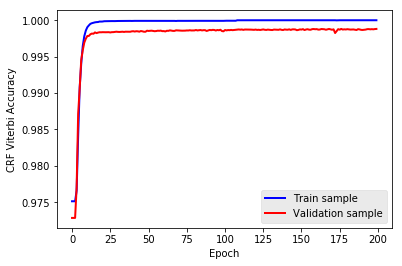

<Figure size 864x864 with 0 Axes>

In [124]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
l1, = ax.plot(hist["crf_viterbi_accuracy"], label = 'Train sample', color='blue', linewidth = 2)
l2, = ax.plot(hist["val_crf_viterbi_accuracy"], label = 'Validation sample',color='red', linewidth = 2)
ax.set(xlabel='Epoch', ylabel='CRF Viterbi Accuracy')
ax.legend((l1,l2),('Train sample','Validation sample'))
plt.show()

In [125]:
!pip install seqeval

     |████████████████████████████████| 51kB 2.5MB/s eta 0:00:011
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16172 sha256=2d5a636dff08d9f88c236e9aaaf015e2d78571f74fd7b143fd3ea89a9e0b5fdc
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [126]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [127]:
train_pred = model.predict(X_train, verbose=1)

1120/1120 [==============================] - 26s 24ms/step


In [128]:
test_pred = model.predict(X_test, verbose=1)

280/280 [==============================] - 6s 23ms/step


In [129]:
# def pred2label(pred):
#     out = []
#     for pred_i in pred:
#         out_i = []
#         for p in pred_i:
#             p_i = np.argmax(p)
#             tag = idx2tag[p_i]
#             if isinstance(tag, float):
#                 tag = str(tag)
#             out_i.append(tag.replace("PAD", "O").replace("nan", "O"))
#         out.append(out_i)
#     return out

In [130]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [131]:
train_pred_labels = pred2label(train_pred)
train_actual_labels = pred2label(y_train)

test_pred_labels = pred2label(test_pred)
test_actual_labels = pred2label(y_test)

In [132]:
print("F1-score: {:.1%}".format(f1_score(train_actual_labels, train_pred_labels)))
print("F1-score: {:.1%}".format(f1_score(test_actual_labels, test_pred_labels)))

F1-score: 99.9%
F1-score: 91.1%


In [133]:
print(classification_report(train_actual_labels, train_pred_labels))

              precision    recall  f1-score   support

 BESKRIVELSE       1.00      1.00      1.00      7617

   micro avg       1.00      1.00      1.00      7617
   macro avg       1.00      1.00      1.00      7617
weighted avg       1.00      1.00      1.00      7617



In [134]:
print(classification_report(test_actual_labels, test_pred_labels))

              precision    recall  f1-score   support

 BESKRIVELSE       0.92      0.91      0.91      2053

   micro avg       0.92      0.91      0.91      2053
   macro avg       0.92      0.91      0.91      2053
weighted avg       0.92      0.91      0.91      2053



In [135]:
model.evaluate(X_test, np.array(y_test))

280/280 [==============================] - 9s 31ms/step


[0.004580638018835868, 0.9988043904304504]

In [136]:
# p = model.predict(np.array([X_test[i]]))
# p = np.argmax(p, axis=-1)
# true = np.argmax(y_test[i], -1)
# print("{},{},{}".format("Word", "True", "Pred"))
# for w, t, pred in zip(X_test[i], true, p[0]):
# #     if w != 0:
#     print("{},{},{}".format(words[w-1], tags[t], tags[pred]))

In [137]:
i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{},{},{}".format("Word", "True", "Pred"))
for w, t, pred in zip(X_test[i], true, p[0]):
#     if w != 0:
    print("{},{},{}".format(words[w-1], tags[t], tags[pred]))

Word,True,Pred
Faktura,O,O
Åbningstider,O,O
Mandag,O,O
-,O,O
fredag:,O,O
Lørdag:,O,O
Søndag:,O,O
6:00,O,O
-,O,O
17:00,O,O
8:00,O,O
-,O,O
14:00,O,O
8:00,O,O
-,O,O
14:00,O,O
inco,O,O
CC,O,O
Glostrup,O,O
A/S,O,O
Ejby,O,O
Industrivej,O,O
111,,O,O
DK,O,O
2600,O,O
Glostrup,O,O
Tlf:,O,O
72108181,O,O
Fax:,O,O
621391,O,O
Gorms,O,O
Food,O,O
&,O,O
Catering,O,O
ApS,O,O
*S*,O,O
Att.,O,O
Christian,O,O
Madsen,O,O
Marielundvej,O,O
34,O,O
A,O,O
2730,O,O
Herlev,O,O
Kortholder:,O,O
Jack,O,O
Christensen,O,O
Økologikontrolmyndighed:,O,O
DK-ØKO-100,O,O
Bank,O,O
896,O,O
1039038,O,O
CVR-nr.,O,O
37589608,O,O
Side,O,O
1,O,O
Fakturanr.,O,O
Fakturadato,O,O
Fakturatidspunkt,O,O
Kundenr.,O,O
Kunde,O,O
CVR-nr.,O,O
Betales,O,O
inden,O,O
Terminal,O,O
Bonnr.,O,O
302,O,O
Eksp.,O,O
96020017,O,O
3302321766,O,O
14,O,O
juni,O,O
2022,O,O
08:19:48,O,O
621391,O,O
29816271,O,O
15,O,O
juni,O,O
2022,O,O
4,O,O
302000326265,O,O
Kortnr.,O,O
Varenr.,O,O
Antal,O,O
Enhed,O,O
Antal,O,O
pr.,O,O
enhed,O,O
Beskrivelse,O,O
Listepris,O,O
exc

In [138]:
# p

In [139]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return s.split()

In [140]:
test_sentence=''
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=0, maxlen=max_len)
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction


In [141]:
len(data)

384608

In [142]:
# get sentences
# data_test
getter_test = SentenceGetter(data)
sent_test = getter_test.get_next()
sentences_test = getter_test.sentences

In [143]:
# pad the sequence - test sample
X_test = [[word2idx[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words-1)

# pad the target - dev sample
y_test = [[tag2idx[w[1]] for w in s] for s in sentences_test]
# y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post")

y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

In [144]:
test_pred = model.predict(X_test, verbose=1)

1400/1400 [==============================] - 31s 22ms/step


In [145]:
test_pred_labels = pred2label(test_pred)
test_actual_labels = pred2label(y_test)

In [146]:
print("F1-score: {:.1%}".format(f1_score(test_actual_labels, test_pred_labels)))

F1-score: 98.1%


In [147]:
print(classification_report(test_actual_labels, test_pred_labels))

              precision    recall  f1-score   support

 BESKRIVELSE       0.98      0.98      0.98      9670

   micro avg       0.98      0.98      0.98      9670
   macro avg       0.98      0.98      0.98      9670
weighted avg       0.98      0.98      0.98      9670



## Example

In [148]:
# d = {'Index_': [1,2,3,4,5,6,7,8,9,10,11,12],
#      'NER': ['PERSONTYPE', 
#              'PERSON', 
#              'ADDRESS', 
#              'PHONENUMBER', 
#              'DATETIME',
#              'ORGANIZATION', 
#              'LOCATION', 
#              'PRODUCT', 
#              'EMAIL', 
#              'MISCELLANEOUS',
#              'URL', 
#              'IP'], 
#      'Sentence' : ['Tổng giám đốc đi công tác tại Phú Yên.',
#                   'Nguyễn Văn Thanh được phong làm NSND.',
#                   'Chiếc điện thoại này cần giao tới địa chỉ số 57, đường Lý Thường Kiệt, p.Trần Hưng Đạo, Hà Nội.',
#                   'Hãy gọi cho cô Hoa vào số điện thoại 0934.456.787.',
#                   '15 giờ sáng ngày 24 tháng 6 năm 2021, xảy ra một vụ cháy tại quận Thanh Xuân.',
#                   'Tòa án nhân dân tối cao là cơ quan xét xử cao nhất của nước Cộng hòa xã hội chủ nghĩa Việt Nam.',
#                   'Đông Nam Á là tiểu vùng địa lý phía đông nam của châu Á.',
#                   'Iphone 14 là phiên bản điện thoại mới nhất của tập đoàn công nghệ Apple.',
#                   'Email của tôi là hanoi@gmail.com.',
#                   'COVID-19 là một bệnh đường hô hấp cấp tính truyền nhiễm gây ra bởi chủng virus corona SARS-CoV-2 và các biến thể của nó.',
#                   'Bạn có thể đọc tin tức tại trang vnexpress.net.',
#                   'Máy tính có IP là 120.126.1.1 hiện đang bị lỗi.']}
# data_sample = pd.DataFrame(d)

In [149]:
# data_sample

In [150]:
# def test_sentence(index):
#     test_sentence=d['Sentence'][index]
#     x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],padding="post", value=0, maxlen=max_len)
#     p = model.predict(np.array([x_test_sent[0]]))
#     p = np.argmax(p, axis=-1)
#     print("{:15}||{}".format("Word", "Prediction"))
#     print(30 * "=")
#     for w, pred in zip(tokenize(test_sentence), p[0]):
#         print("{:15}: {:5}".format(w, tags[pred]))

In [151]:
def test_sentence_sample(test_sentence):
    #test_sentence="Anh Mai đang bị hâm"
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],padding="post", value=0, maxlen=max_len)
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(tokenize(test_sentence), p[0]):
        print("{:15}: {:5}".format(w, tags[pred]))

In [152]:
test_sentence_sample("Frostvarer 201204 Jordbær 1 Total FRIGODAN 1 PS (2,5 KG)")

Word           ||Prediction
Frostvarer     : I-BESKRIVELSE
201204         : B-BESKRIVELSE
Jordbær        : I-BESKRIVELSE
1              : O    
Total          : O    
FRIGODAN       : O    
1              : O    
PS             : O    
(2,5           : O    
KG)            : O    


In [153]:
!pip install  gdown

In [154]:
!gdown https://drive.google.com/file/d/1Y3jPwcGvO-bndkEKNNTYu4vJHreroezj/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1Y3jPwcGvO-bndkEKNNTYu4vJHreroezj
To: /kaggle/working/inv-Tl91T-1630501455.pdf
100%|██████████████████████████████████████| 91.6k/91.6k [00:00<00:00, 44.1MB/s]


In [155]:
conda install -c conda-forge pdfminer.six

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pdfminer.six


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.7.22  |       hbcca054_0         146 KB  conda-forge
    certifi-2020.6.20          |     pyhd3eb1b0_3         155 KB
    openssl-1.0.2u             |       h516909a_0         3.2 MB  conda-forge
    pdfminer.six-20201018      |     pyhd8ed1ab_3         4.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.3 MB

The following NEW packages will be INSTALLED:

  pdfminer.six       conda-forge/noarch::pdfminer.six-20201018-pyhd

In [156]:
import csv
from pdfminer.high_level import extract_text

pdf_file = "/kaggle/working/inv-Tl91T-1630501455.pdf"
csv_file = "/kaggle/working/output.csv"

# Extract text from pdf
text = extract_text(pdf_file)
# Generate tokens
tokens = text.split()

print(tokens)

check =  ' '.join(tokens)
print(check)

['Totalleverandør', 'af', 'fødevarer', 'og', 'nonfood-artikler', 'House', 'of', 'Shawarma', 'Fantastic', 'Food', 'Aps', 'Rosengårdcentret', 'Ørbækvej', '75', '5220', 'Odense', 'SØ', 'Kundenr.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '79874', 'Økologikontrolmyndighed:', 'DK-ØKO-100', 'Kopi', '*10-3162056*', 'Faktura', '.', '.', '.', '.', '.', '.', 'Bogføringsdato', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'Rute', 'Sælger', 'Betalingsbetingels', '.', '.', '.', '.', '.', '.', 'Betales', 'inden', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'Side', '10-3162056', '09-07-21', '55', 'CGOPHA/CGOCLG', '30', 'Dage', 'Netto', '08-08-21', '1', '59007', 'Nummer', 'Beskrivelse', 'Mærke', 'Antal', 'Enhed', 'Salgspris', 'Beløb', '206873', 'Agurk', 'm/Film', '(NL)', '206928', 'Koriander', 'i', 'Bundt', '(KE)', '206863', 'Løg', 'i', 'PS', '(DK)', '229956', 'Persille', 'Bredbladet', 'i', 'Bundt', '(IT)', '206826', 'Salat', 'Iceberg', '(NL)', '218441', 'Tomat', 'Udenlandsk', 

In [157]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-78lflzgz
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-78lflzgz
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=efc9f570203e265a3714b6dacd397e6114f647d6d1ba8ea78e65b47f6cdc503a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9px3k7rp/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [158]:
import numpy as np
import csv
import re
import joblib

from collections import OrderedDict
from pdfminer.high_level import extract_text

from keras.models import load_model
from keras_contrib.layers import CRF
from keras.preprocessing.sequence import pad_sequences


max_len = 1000
model_predict = load_model('/kaggle/working/model.h5', custom_objects={"CRF": CRF, 'crf_loss': crf_layer.loss_function, 'crf_viterbi_accuracy': crf_layer.accuracy})


# Load the word2idx and tag2idx dictionaries
with open('/kaggle/working/words.pkl', 'rb') as f:
    words = joblib.load(f)
    
with open('/kaggle/working/tags.pkl', 'rb') as f:
    tags = joblib.load(f)

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in tag2idx.items()}


def test_sentence_sample(test_sentence):
    results = []
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],padding="post", value=0, maxlen=max_len)
    p = model_predict.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    for w, pred in zip(tokenize(test_sentence), p[0]):
        results.append([w, tags[pred]])
    return results
        
    
def tokenize(s): return s.split()



pdf_file = "/kaggle/working/inv-Tl91T-1630501455.pdf"
csv_file = "output.csv"

# Extract text from pdf
text = extract_text(pdf_file)
# Generate tokens
# tokens = text.split()

# print(tokens)

# check =  ' '.join(tokens)
# print(check)

results = test_sentence_sample(text)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [159]:
# results

In [160]:
def process_text_file(input_text, output_file_path):
    # Split the input text into lines
    lines = input_text.split('\n')

    # Create a CSV writer
    with open(output_file_path, 'w', newline='') as output_file:
        writer = csv.writer(output_file)

        # Write the header row
        writer.writerow(["PRODUCT-NUMBER", "PRODUCT-VAT", "TOTAL-AMOUNT", "CVR"])

        # Initialize variables
        product_number = ''
        product_vat = ''
        total_amount = ''
        cvrs = []

        # Loop through the lines in the input file
        for line in lines:
            # Strip any leading/trailing whitespace
            line = line.strip()

            # If the line contains one of the desired keys
            if "B-TOTAL-AMOUNT" in line:
                pattern = r'"(.*?)"'  # Pattern to match any characters inside double quotes
                match = re.search(pattern, line)

                if match:
                    total_amount = match.group(1)

            elif "B-PRODUCT-VAT" in line:
                pattern = r'"(.*?)"'  # Pattern to match any characters inside double quotes
                match = re.search(pattern, line)

                if match:
                    product_vat = match.group(1)

            elif "B-CVR" in line or "I-CVR" in line:
                # Split the line by commas
                values = line.split(',')

                # Get the second word of the line
                second_word = values[1]
                cvrs.append(second_word)

            elif "B-PRODUCT-NUMBER" in line:
                # Split the line by commas
                values = line.split(',')

                # Get the second word of the line
                product_number = values[1]

        # Write the values to the CSV file
        cvrsu = list(OrderedDict.fromkeys(cvrs))
        writer.writerow([product_number, product_vat, total_amount, ' '.join(cvrsu)])

        # Return output as a dictionary
        return {"PRODUCT-NUMBER": product_number, "PRODUCT-VAT": product_vat, "TOTAL-AMOUNT": total_amount, "CVR": cvrsu}

In [161]:
def process_text_file(input_text, output_file_path):
    # Split the input text into lines
#     lines = input_text.split('\n')

    # Create a CSV writer
    with open(output_file_path, 'w', newline='') as output_file:
        writer = csv.writer(output_file)

        # Write the header row
        writer.writerow(["PRODUCT-NUMBER", "PRODUCT-VAT", "TOTAL-AMOUNT", "CVR"])

        # Initialize variables
        product_number = []
        product_vat = []
        total_amount = []
        cvrs = []

        # Loop through the lines in the input file
        for line in input_text:
            # Strip any leading/trailing whitespace

            # If the line contains one of the desired keys
            if "B-TOTAL-AMOUNT" in line[1]:
                total_amount = line[0]

            elif "B-PRODUCT-VAT" in line[1] or "I-PRODUCT-VAT" in line[1]:
                product_vat.append(line[0])

            elif "B-CVR" in line[1] or "I-CVR" in line[1]:
                # Split the line by commas
#                 values = line.split(',')
                # Get the second word of the line
#                 second_word = values[1]
                cvrs.append(line[0])

            elif "B-PRODUCT-NUMBER" in line[1] or "I-PRODUCT-NUMBER" in line[1]:
                # Split the line by commas
#                 values = line.split(',')

                # Get the second word of the line
                product_number.append(line[0])

        # Write the values to the CSV file
        cvrsu = list(OrderedDict.fromkeys(cvrs))
        writer.writerow([product_number, product_vat, total_amount, ''.join(cvrsu)])

        # Return output as a dictionary
        return {"PRODUCT-NUMBER": product_number, "PRODUCT-VAT": product_vat, "TOTAL-AMOUNT": total_amount, "CVR": ''.join(cvrsu)}

In [162]:
results

[['Totalleverandør', 'I-BESKRIVELSE'],
 ['af', 'O'],
 ['fødevarer', 'B-BESKRIVELSE'],
 ['og', 'I-BESKRIVELSE'],
 ['nonfood-artikler', 'B-BESKRIVELSE'],
 ['House', 'I-BESKRIVELSE'],
 ['of', 'I-BESKRIVELSE'],
 ['Shawarma', 'I-BESKRIVELSE'],
 ['Fantastic', 'O'],
 ['Food', 'O'],
 ['Aps', 'O'],
 ['Rosengårdcentret', 'O'],
 ['Ørbækvej', 'O'],
 ['75', 'O'],
 ['5220', 'O'],
 ['Odense', 'O'],
 ['SØ', 'O'],
 ['Kundenr.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['79874', 'O'],
 ['Økologikontrolmyndighed:', 'O'],
 ['DK-ØKO-100', 'O'],
 ['Kopi', 'O'],
 ['*10-3162056*', 'O'],
 ['Faktura', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['Bogføringsdato', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['.', 'O'],
 ['Rute', 'O'],
 ['Sælger', 'O'],
 ['Betalingsbetingels', 'O'],
 ['.', 'O'],
 ['.

In [163]:
process_text_file(results, 'input.csv')

{'PRODUCT-NUMBER': [], 'PRODUCT-VAT': [], 'TOTAL-AMOUNT': [], 'CVR': ''}

In [164]:
# !cd /kaggle/working

In [165]:
# !cd ..

In [166]:
# from IPython.display import FileLink
# FileLink(r'model.h5')

In [167]:
+

SyntaxError: invalid syntax (<ipython-input-167-0b024bbfe84e>, line 1)